In [81]:
import re
import string

import pandas as pd
import seaborn as sns
from matplotlib.pylab import plt

from flask import Flask, request, render_template

try:
    from collections.abc import Sequence
except ImportError:
    from collections import Sequence

from sklearn import metrics
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from collections.abc import Mapping
from collections.abc import MutableMapping
from collections.abc import Sequence

import pickle
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
from nltk.stem import WordNetLemmatizer



In [48]:
dataset = pd.read_csv('Dataset/WELFake_Dataset.csv')

In [49]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [50]:
dataset.head(5)

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


## Remove unnecessary columns ##

In [51]:
del dataset['Unnamed: 0']

In [52]:
dataset.head(5)

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


## Drop NaN Values

In [53]:
dataset.isnull().sum()

title    558
text      39
label      0
dtype: int64

In [54]:
# drop na values 
dataset = dataset.dropna()
dataset = dataset.reset_index(drop=True)

In [55]:
dataset.isnull().sum()

title    0
text     0
label    0
dtype: int64

In [56]:
dataset

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
2,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
3,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
4,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1
...,...,...,...
71532,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
71533,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
71534,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
71535,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


## Label Distribution

<Axes: xlabel='label'>

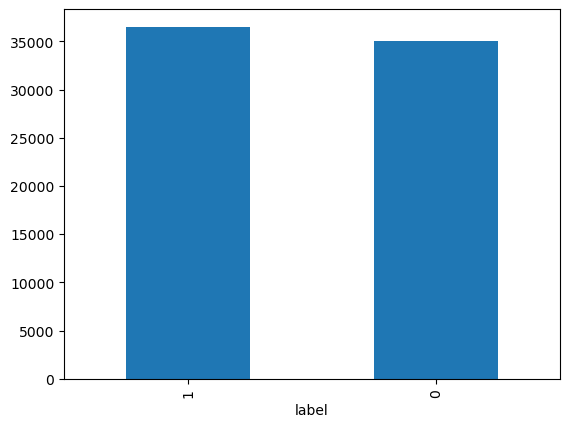

In [64]:
# class distribution
dataset['label'].value_counts().plot.bar()

In [ ]:
## Word count Distribution of Real and Fake News 
# use histogram

In [ ]:
# plot most common words in both fake and real news 

In [57]:
dataset['Text_length'] = dataset.text.str.split().str.len()
dataset.head(5)

,title,text,label,Text_length
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,871
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,34
2,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,1321
3,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,329
4,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,244


In [80]:
max_text_length = max(dataset['Text_length'])
max_text_length

24234

In [58]:
dataset['title_text'] = dataset['title'] + " " + dataset['text']

In [60]:
print(f"Sample Title: {dataset['title'][1]}\n")
print(f"Sample Text: {dataset['text'][1]}\n")
print(f"Sample Title Text: {dataset['title_text'][1]}")

Sample Title: UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MOST CHARLOTTE RIOTERS WERE “PEACEFUL” PROTESTERS…In Her Home State Of North Carolina [VIDEO]

Sample Text:  Now, most of the demonstrators gathered last night were exercising their constitutional and protected right to peaceful protest in order to raise issues and create change.    Loretta Lynch aka Eric Holder in a skirt

Sample Title Text: UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MOST CHARLOTTE RIOTERS WERE “PEACEFUL” PROTESTERS…In Her Home State Of North Carolina [VIDEO]  Now, most of the demonstrators gathered last night were exercising their constitutional and protected right to peaceful protest in order to raise issues and create change.    Loretta Lynch aka Eric Holder in a skirt


## Preprocess the text

In [120]:
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
le = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(re.compile('<.*?>'), '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub('\d+', '', text)
    text = text.replace("'", "")
    text = text.replace('“', '')
    text = text.replace('”', '')
    text = text.replace("’", "")
    text = text.replace("'", "")
    text = text.strip("\'")

    word_tokens = text.split()
    word_tokens = [le.lemmatize(w) for w in word_tokens if not w in stop_words]

    cleaned_text = " ".join(word_tokens)
    cleaned_text = re.sub(r"\b[a-zA-Z]\b", "", cleaned_text)
    cleaned_text = " ".join(cleaned_text.split())

    return cleaned_text

[nltk_data] Downloading package wordnet to /Users/Naveen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [121]:
dataset['title_text'] = dataset['title_text'].apply(preprocess_text)

In [61]:
len(dataset)

71537

In [62]:
dataset.shape

(71537, 5)

## Split the data into training and testing

In [148]:
X = dataset['title_text']
y = dataset['label']

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Vectorization

In [150]:
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

## Train the model

In [145]:
classifier = RandomForestClassifier()

In [151]:
classifier.fit(X_train, y_train)

RandomForestClassifier()

In [152]:
# evaluate the model
y_pred = classifier.predict(X_test)

accu = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Accuracy:', accu)
print('Precision:', prec)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.938076600503215
Precision: 0.932596534315732
Recall: 0.9457589594575896
F1 Score: 0.9391316295685628


In [154]:
# check results
confusion_matrix(y_test, y_pred)

array([[6587,  494],
       [ 392, 6835]])

In [160]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
0,0.943831,0.930236,0.936984,7081.000000
1,0.932597,0.945759,0.939132,7227.000000
accuracy,0.938077,0.938077,0.938077,0.938077
macro avg,0.938214,0.937997,0.938058,14308.000000
weighted avg,0.938157,0.938077,0.938069,14308.000000


In [ ]:
# test other ML models
def train_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    y_pred = classifier.predict(X_test)

    accu = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print('Accuracy:', accu)
    print('Precision:', prec)
    print('Recall:', recall)
    print('F1 Score:', f1)

train_model(SVC(), X_train, y_train, X_test, y_test)

## Hyperparameter Tuning

In [ ]:
grid_param_rf = {
    'classifier__n_estimators': [200, 300, 400, 500, 600],
    'classifier__min_samples_split': [2, 4, 6],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_depth': [16, 18, 20, 30, 40, 50]
    }

grid_param_svm = {
    'classifier__tol': [0.1, 0.01, 0.001, 0.0001],
    'classifier__C': [x for x in range(200)]
}

# def random_search(params):
#     clf = RandomizedSearchCV(estimator=base_classifier, param_distributions=params, cv=5, n_iter=50, n_jobs=-1)
#     return clf

clf = grid_search(grid_param_rf)
# clf = random_search(grid_param_rf)

clf.fit(X_train_tfidf, y_train)
print('Retrieving best parameters....')
print(clf.best_params_)

## Testing the model

In [163]:
# save model to disk
model_filename = 'RF_Model.pk1'
pickle.dump(classifier, open(model_filename, 'wb'))

In [164]:
# save vectorizer to disk
pickle.dump(tfidf, open("vectorizer.pickle", "wb"))

In [63]:
# load model
loaded_model = pickle.load(open('RF_Model.pk1', 'rb'))

In [64]:
# load vectorizer
loaded_vectorizer = pickle.load(open("vectorizer.pickle", "rb"))

In [73]:
X = loaded_vectorizer.transform([dataset['title_text'][71532]])

In [74]:
y_predictions = loaded_model.predict(X)

In [75]:
# predicted that that its a real news
y_predictions

array([0])

In [77]:
if y_predictions == 1:
    print("The news is Real")
else:
    print("The news is Fake")

The news is Fake


## Deployment 

In [78]:
app = Flask(__name__)

In [79]:
@app.route('/')
def home():
    return render_template('index.html')

In [7]:
@app.route('/predict', methods=['POST'])
def predict():
    pred = []
    text = request.form
    print(text.to_dict())
    for key, value in text.items():
        X = loaded_vectorizer.transform([value])
        y_predict = loaded_model.predict(X)
        pred.append(y_predict)

    if 1 in pred:
        result = 'Real'
    elif 0 in pred:
        result = 'Fake'
    else:
        result = 'Error'

    return render_template('predictions.html', result=result, text=text)

In [ ]:
if __name__ == '__main__':
    app.debug = True
    app.run()